In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset

/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-02-23 18:51:15.831441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 18:51:15.850477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1

In [2]:
torch.cuda.empty_cache()

# Load Dataset

In [3]:
# os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
# os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


# Train

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    # learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    # weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=500,
    logging_first_step=True,
)


wandb.init(
    project="bert_tiny_mnli",
    name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_tiny",
    config=training_args.to_dict(),
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["loss", "forgetting"]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Currently logged in as: hugomilosz (hugomilosz-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/vol/bitbucket/hrm20/fyp/trainer.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.756159,0.668161
2,0.751600,0.725695,0.688334
3,0.709900,0.704621,0.696077
4,0.698000,0.706405,0.696893


/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/vol/bitbucket/hrm20/env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=49088, training_loss=0.7605020446408992, metrics={'train_runtime': 1916.8959, 'train_samples_per_second': 819.454, 'train_steps_per_second': 25.608, 'total_flos': 499078424672256.0, 'train_loss': 0.7605020446408992, 'epoch': 4.0})

# Analysis

## Forgetting

In [5]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
forgetting_results

{0: 1,
 1: 1,
 2: 0,
 3: 1,
 4: 0,
 5: 0,
 6: 1,
 7: 0,
 8: 1,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: -1,
 16: 0,
 17: 1,
 18: 1,
 19: 0,
 20: 0,
 21: 0,
 22: 1,
 23: 2,
 24: 1,
 25: 0,
 26: 0,
 27: 1,
 28: 1,
 29: 1,
 30: 0,
 31: 1,
 32: 0,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 0,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 0,
 43: 0,
 44: 0,
 45: 1,
 46: 1,
 47: 0,
 48: 0,
 49: 0,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 0,
 60: 1,
 61: 0,
 62: 1,
 63: 0,
 64: 0,
 65: 0,
 66: 1,
 67: 0,
 68: 0,
 69: 1,
 70: 2,
 71: 1,
 72: 0,
 73: 1,
 74: 1,
 75: 0,
 76: 1,
 77: 1,
 78: 1,
 79: 0,
 80: 1,
 81: 0,
 82: 0,
 83: 0,
 84: 1,
 85: 1,
 86: -1,
 87: 0,
 88: 0,
 89: 1,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 1,
 95: 0,
 96: 1,
 97: -1,
 98: 1,
 99: 1,
 100: 0,
 101: 0,
 102: 1,
 103: 1,
 104: 0,
 105: 0,
 106: 2,
 107: 1,
 108: 0,
 109: 2,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 0,
 117: 1,
 118: 1,
 119: 0,
 120: 1,
 121: 1,
 122: 1,


In [6]:
loss = trainer.get_unified_stats()['loss_stats']['epoch_losses']
epoch_losses = loss

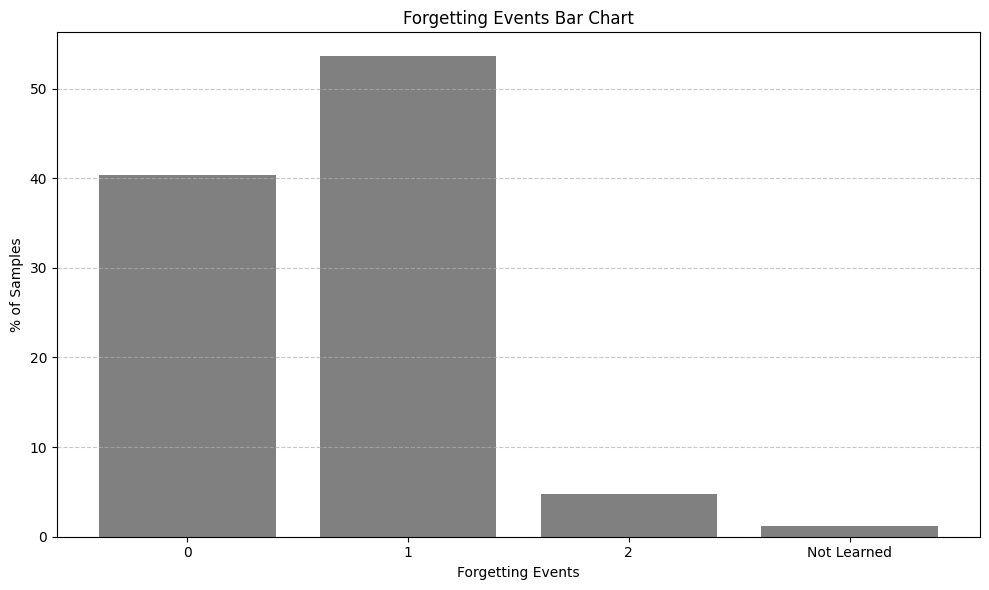

In [7]:
# Count freqs of forgetting events
forgetting_counts = {}
for value in forgetting_results.values():
    if value not in forgetting_counts:
        forgetting_counts[value] = 0
    forgetting_counts[value] += 1

# Separate not-learned from other labels
forgetting_keys = sorted([k for k in forgetting_counts.keys() if k != -1])
forgetting_labels = forgetting_keys + ["Not Learned"]

total_samples = len(train_dataset)

# Calculate percentages
forgetting_values = [forgetting_counts[k] / total_samples * 100 for k in forgetting_keys]
forgetting_values.append(forgetting_counts[-1] / total_samples * 100)

# Plot chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(forgetting_labels)), forgetting_values, color='gray')

plt.xticks(range(len(forgetting_labels)), forgetting_labels)
plt.xlabel("Forgetting Events")
plt.ylabel("% of Samples")
plt.title("Forgetting Events Bar Chart")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()


In [8]:
print(forgetting_counts)

{1: 210484, 0: 158641, -1: 4736, 2: 18841}


## Losses

In [9]:
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
per_sample_losses

{0: [1.1051020622253418, 0.255237877368927, 0.0, 1.9154863357543945],
 1: [1.132187843322754, 0.9487345814704895, 0.0, 0.12892502546310425],
 2: [1.261638879776001, 0.9831305742263794, 0.0, 0.48055481910705566],
 3: [1.0497803688049316, 1.754736304283142, 0.0, 0.2943447232246399],
 4: [1.0161628723144531, 0.5197588801383972, 0.0, 0.6229469180107117],
 5: [1.1343662738800049, 0.7000378966331482, 0.0, 0.4479527473449707],
 6: [1.0212516784667969, 1.4748022556304932, 0.0, 0.10421460121870041],
 7: [1.0353333950042725, 0.08097489178180695, 0.0, 0.25019413232803345],
 8: [0.970706582069397, 0.09157947450876236, 0.0, 1.1445916891098022],
 9: [1.0767128467559814, 0.09707770496606827, 0.0, 0.040042996406555176],
 10: [1.096032977104187, 3.4682722091674805, 0.0, 0.08770953863859177],
 11: [1.1198830604553223, 0.12208268791437149, 0.0, 0.41549354791641235],
 12: [1.1441949605941772, 0.8197635412216187, 0.0, 0.6438368558883667],
 13: [1.074190616607666, 0.34508880972862244, 0.0, 0.582481384277343

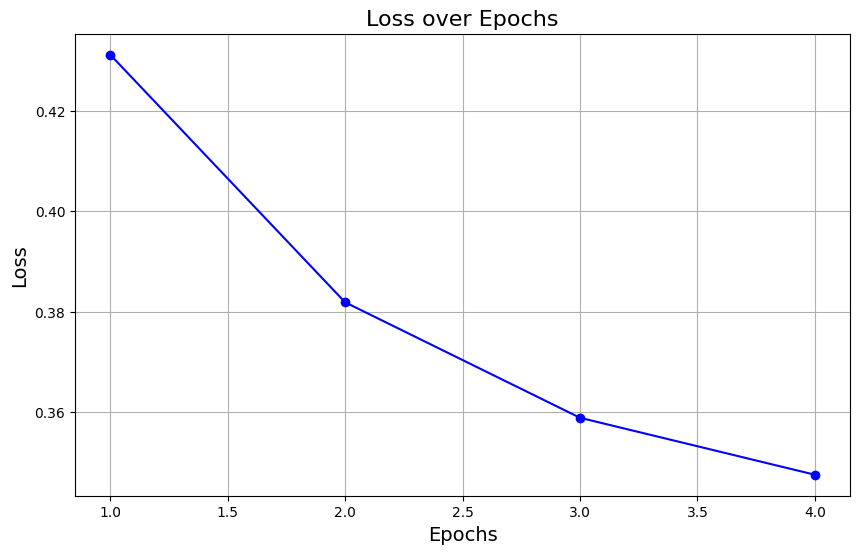

[0.4311200147992847, 0.38183794479566563, 0.35885455119822063, 0.34751295011312044]


In [10]:
# Plot the average loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')

plt.title("Loss over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()
print(epoch_losses)

In [11]:
# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialize counters for train and validation
results = {
    "train": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
    "validation_matched": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
}

## Example Groups

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Load the MNLI dataset from Hugging Face
mnli = load_dataset('multi_nli')

# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialise data structures to store results
results = {
    "Contradiction with High Word Overlap": [],
    "Entailment with High Word Overlap": [],
}

# Filter indices for each group
for idx, example in enumerate(mnli["train"]):
    premise = example["premise"]
    hypothesis = example["hypothesis"]
    label = example["label"]

    overlap_ratio = compute_overlap(premise, hypothesis)
    high_overlap = overlap_ratio >= 0.8  # Threshold set to 80%

    if label == 2 and high_overlap:  # Contradiction with High Word Overlap
        results["Contradiction with High Word Overlap"].append(idx)
    elif label == 0 and high_overlap:  # Entailment with High Word Overlap
        results["Entailment with High Word Overlap"].append(idx)

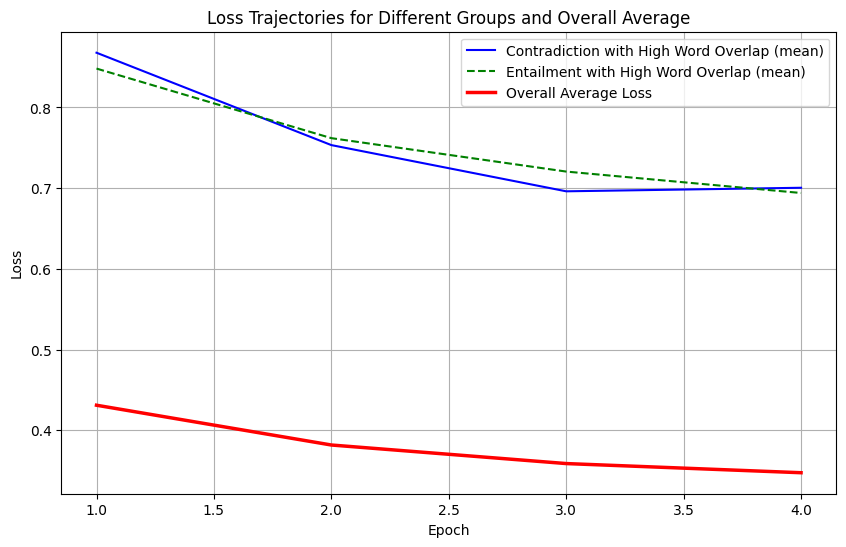

In [ ]:
plt.figure(figsize=(10, 6))
line_styles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

all_losses = np.array(trainer.loss_tracker.losses)

# Plot for each group
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        print(f"No examples in the group {group}.")
        continue
    
    # Get losses for this group's samples across all epochs
    group_losses = all_losses[:, indices]
    group_losses[group_losses == 0.0] = np.nan
    avg_loss_per_epoch = np.nanmean(group_losses, axis=1)
    
    # Plot
    plt.plot(range(1, len(avg_loss_per_epoch) + 1), 
             avg_loss_per_epoch,
             label=f"{group} (mean)",
             linestyle=line_styles[idx % len(line_styles)],
             color=colors[idx % len(colors)])

# Plot overall average
overall_avg_per_epoch = np.mean(all_losses, axis=1)
plt.plot(range(1, len(overall_avg_per_epoch) + 1),
         overall_avg_per_epoch,
         label='Overall Average Loss',
         linestyle='-',
         color=colors[-1],
         linewidth=2.5)

plt.title("Loss Trajectories for Different Groups and Overall Average")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
plt.savefig("group_loss_trajectories.png")
wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})

<Figure size 640x480 with 0 Axes>

In [15]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    "final_forgetting_stats": forgetting_results,
})

In [16]:
wandb.finish()

eval/accuracy,▁▆██
eval/loss,█▄▁▁
eval/runtime,▁▅█▁
eval/samples_per_second,█▄▁█
eval/steps_per_second,█▄▁█
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███████
train/grad_norm,▁▄▆▄▆▅▆▆▄▅▆▆▅▄▇▇▅▆█▅▆▆▇▅▆▆▇▅▆▄▆▅▇█▅█▇▇▅▇
train/learning_rate,█████▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁
train/loss,█▇▆▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
eval/accuracy,0.69689
